In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from matplotlib.colors import LogNorm
from scipy.integrate import odeint
sns.set_context("talk", font_scale=1.4)


# for using LaTeX fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

#### Load the V-Dem data

In [4]:
VDemDataRaw = pd.read_csv('./../data/V-Dem/V-Dem-CY-Core-v12.csv')
# extract the columns we need
VDemData =VDemDataRaw[['country_name','country_text_id','country_id','year','v2x_polyarchy']]
VDemData['country'] = VDemData['country_name']

/opt/anaconda3/envs/networkScience/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Explore the data

Text(0.5, 0, 'v2x polyarchy')

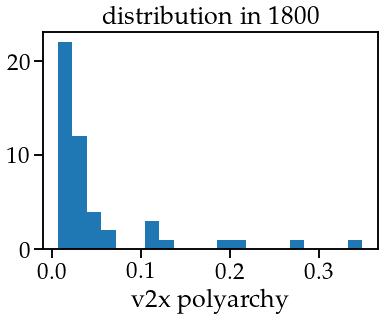

In [5]:
VDemDataSelected = VDemData[VDemData['year']==1800]
plt.hist(VDemDataSelected['v2x_polyarchy'],bins=21)
plt.title('distribution in 1800')
plt.xlabel('v2x polyarchy')

Text(0.5, 0, 'v2x polyarchy')

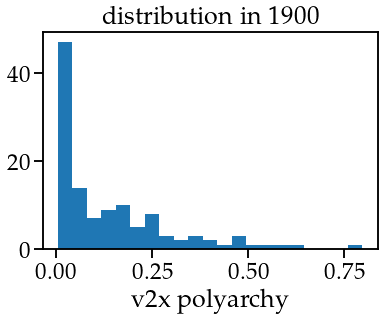

In [6]:
VDemDataSelected = VDemData[VDemData['year']==1900]
plt.hist(VDemDataSelected['v2x_polyarchy'],bins=21)
plt.title('distribution in 1900')
plt.xlabel('v2x polyarchy')

Text(0.5, 0, 'v2x polyarchy')

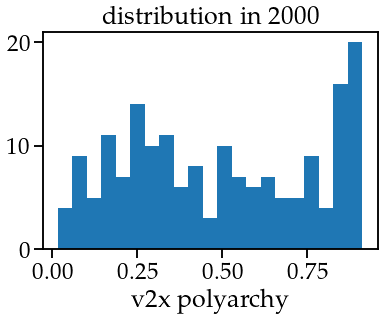

In [7]:
VDemDataSelected = VDemData[VDemData['year']==2000]
plt.hist(VDemDataSelected['v2x_polyarchy'],bins=21)
plt.title('distribution in 2000')
plt.xlabel('v2x polyarchy')

Text(0.5, 0, 'v2x polyarchy')

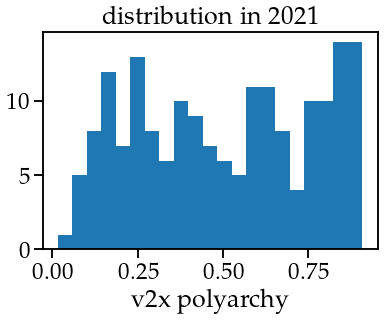

In [8]:
VDemDataSelected = VDemData[VDemData['year']==2021]
plt.hist(VDemDataSelected['v2x_polyarchy'],bins=21)
plt.title('distribution in 2021')
plt.xlabel('v2x polyarchy')

Text(0, 0.5, 'v2x polyarchy')

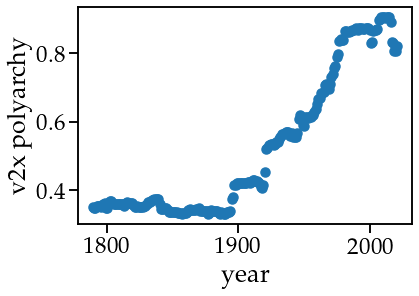

In [9]:
### Plot time series for certain data sets
VDemDataCountry = VDemData[VDemData['country_name']=='United States of America']

plt.scatter(VDemDataCountry['year'],VDemDataCountry['v2x_polyarchy'])
plt.xlabel('year')
plt.ylabel('v2x polyarchy')


### Analysis 

In [56]:
max(VDemData['v2x_polyarchy'])

0.926

In [26]:
## discretises into 21 groups

VDemData['v2x_polyarchy_discretised'] = round(VDemData['v2x_polyarchy']/max(VDemData['v2x_polyarchy'])*21-11)

#VDemData['v2x_polyarchy_discretised'] = round(VDemData['v2x_polyarchy']*21-11)

/opt/anaconda3/envs/networkScience/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Infer Markov Chain transition matrix from political regime time-series data

In [27]:
nCountries = len(VDemData['country'].unique()) # numer of countries
print(nCountries)

202


In [28]:
# do some cleaning
timeSeriesVDEM = VDemData.dropna(subset=['year', 'country', 'v2x_polyarchy_discretised'])

In [29]:
# functions to calculating the transition probabilities

def estimateTransitionMatrix(data,approach='frequentist',scoreName="v2x_polyarchy_discretised"):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')[scoreName].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

def computeSteadyStateBruteForce(transitionMatrix,nSteps,initialCondition=0):
    # computes it the brutal way with iterating the transition
    
    n=transitionMatrix.shape[0] # number of Markov states
    
    if initialCondition==0:
        # if it is zero use a random vector
        x = np.random.rand(n)
        x = x / np.sum(x)
    else:
        # set it to the intial condition that we provided
        x= initialCondition
    # fo over each step
    for i in np.arange(nSteps):
        #x= P_allCountries.dot(x)
        x= x.dot(transitionMatrix)
    
    return(x)

def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


def simulateMarkovChain(transitionMatrix,initialCondition,nSteps=100):
    
    n=transitionMatrix.shape[0] # number of states
    
    stateVector=[initialCondition]
    for i in np.arange(nSteps):
        newstate = np.random.choice(np.arange(n), p=transitionMatrix[stateVector[i],:])
        stateVector.append(newstate)
    return(stateVector)
    

def computeHittingTime(transitionMatrix,initialCondition,hittingTarget,rel):
    
    n=transitionMatrix.shape[0] # number of states
    
    hittingTimes = np.zeros(rel)
    
    # go over realisations
    for r in np.arange(rel):
        t=0
        oldstate = initialCondition # we start at the initial condition
        while ((oldstate in hittingTarget) == False):
            t=t+1
            newstate = np.random.choice(np.arange(n), p=transitionMatrix[oldstate,:])
            oldstate = newstate
        # save the number of steps needed
        hittingTimes[r] = t
    return(hittingTimes)  


def createSimpleMarkovChain():
    
    P=np.zeros((2,2)) # empty transition matrix
    
    P[0,0] = 0.9
    P[0,1] = 0.1
    P[1,0] = 0.5
    P[1,1] = 0.5
    
    return(P)

# Analyse the actual data
## Frequentist approach 

In [30]:
P_allCountries = estimateTransitionMatrix(timeSeriesVDEM,scoreName='v2x_polyarchy_discretised')


Text(0.5, 1.0, 'estimated transition probabilities, $p_{ij}$ [$\\%$] (frequentist approach)')

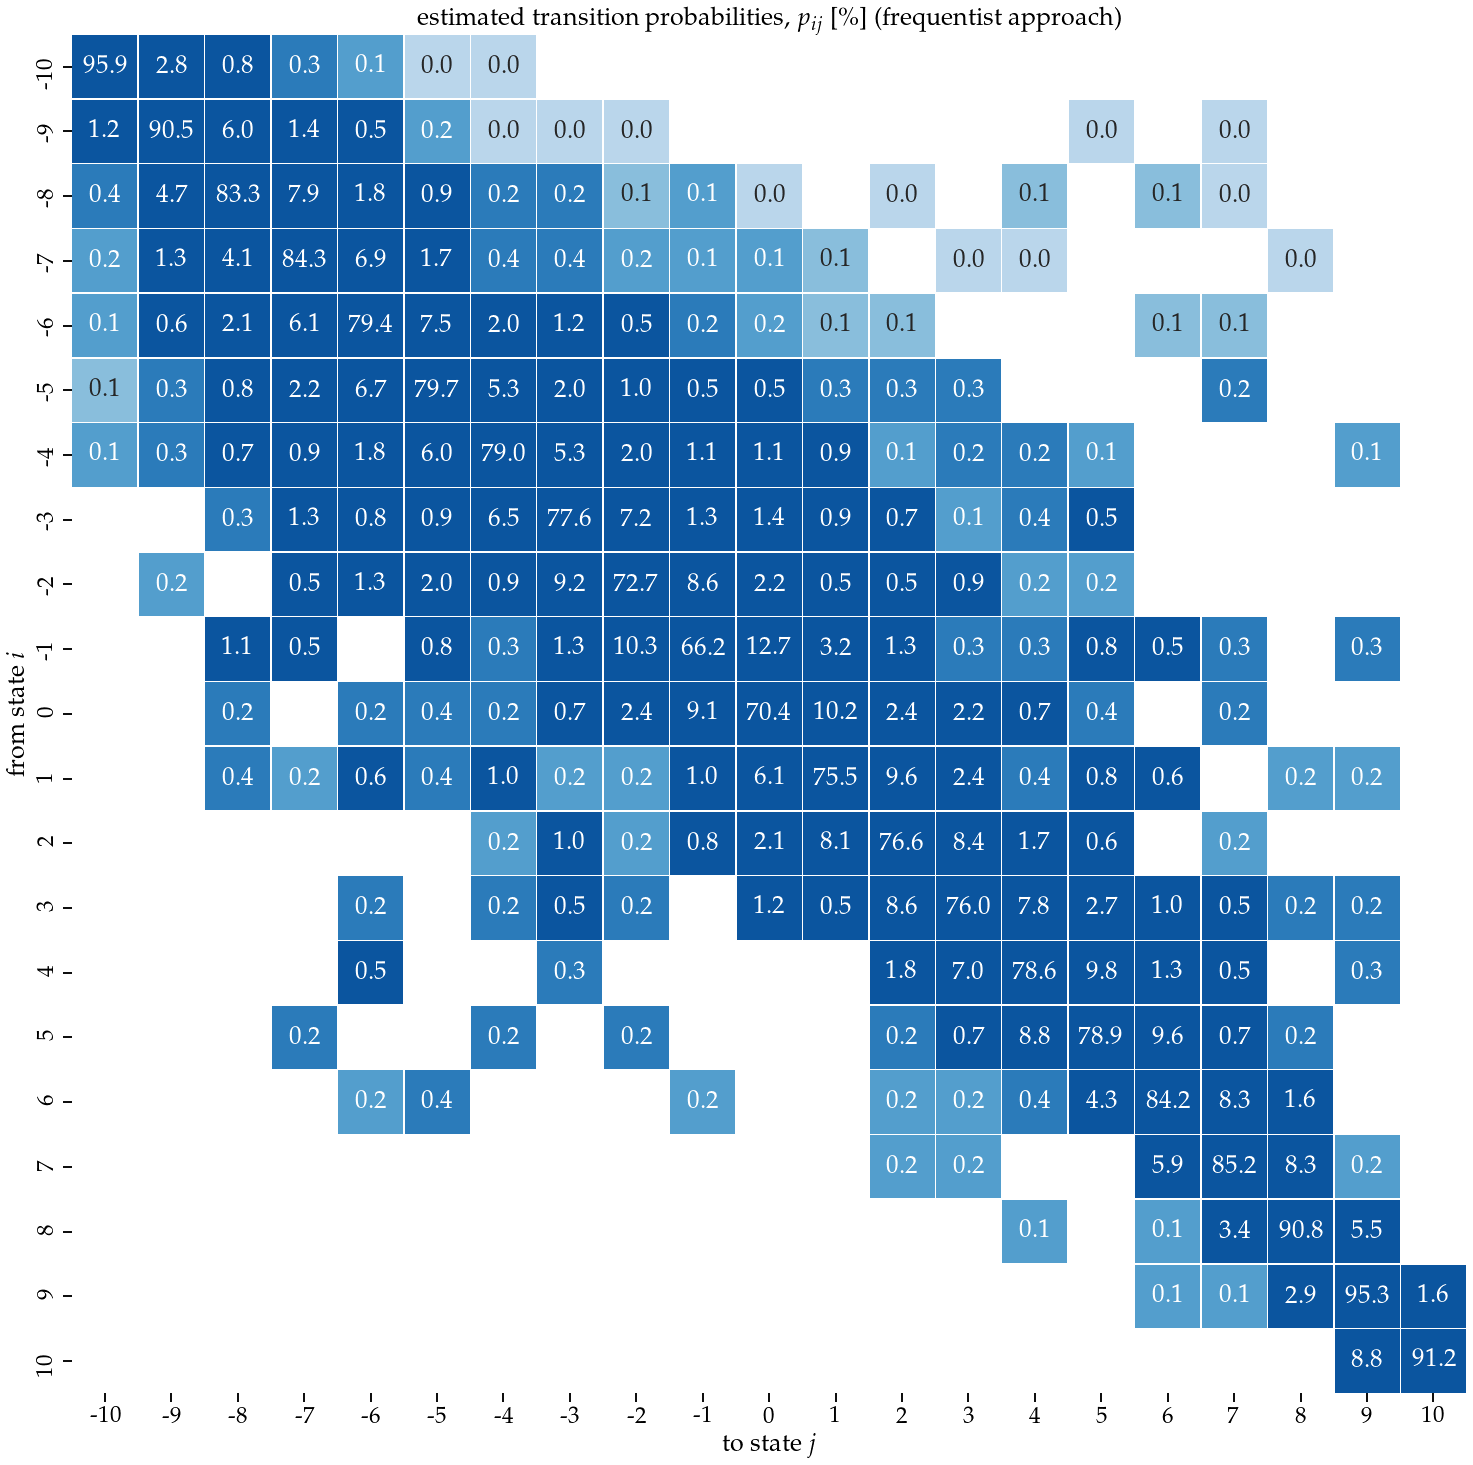

In [31]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries.min()+0.01, vmax=P_allCountries.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$] (frequentist approach)')
#plt.savefig('./../results/supplementaryFigures/FigS1-estimatedTransitionProbabilitiesFrequentist.pdf')

### Bayesian approach

In [32]:
P_allCountries_Bayes = estimateTransitionMatrix(timeSeriesVDEM,approach='bayesian')


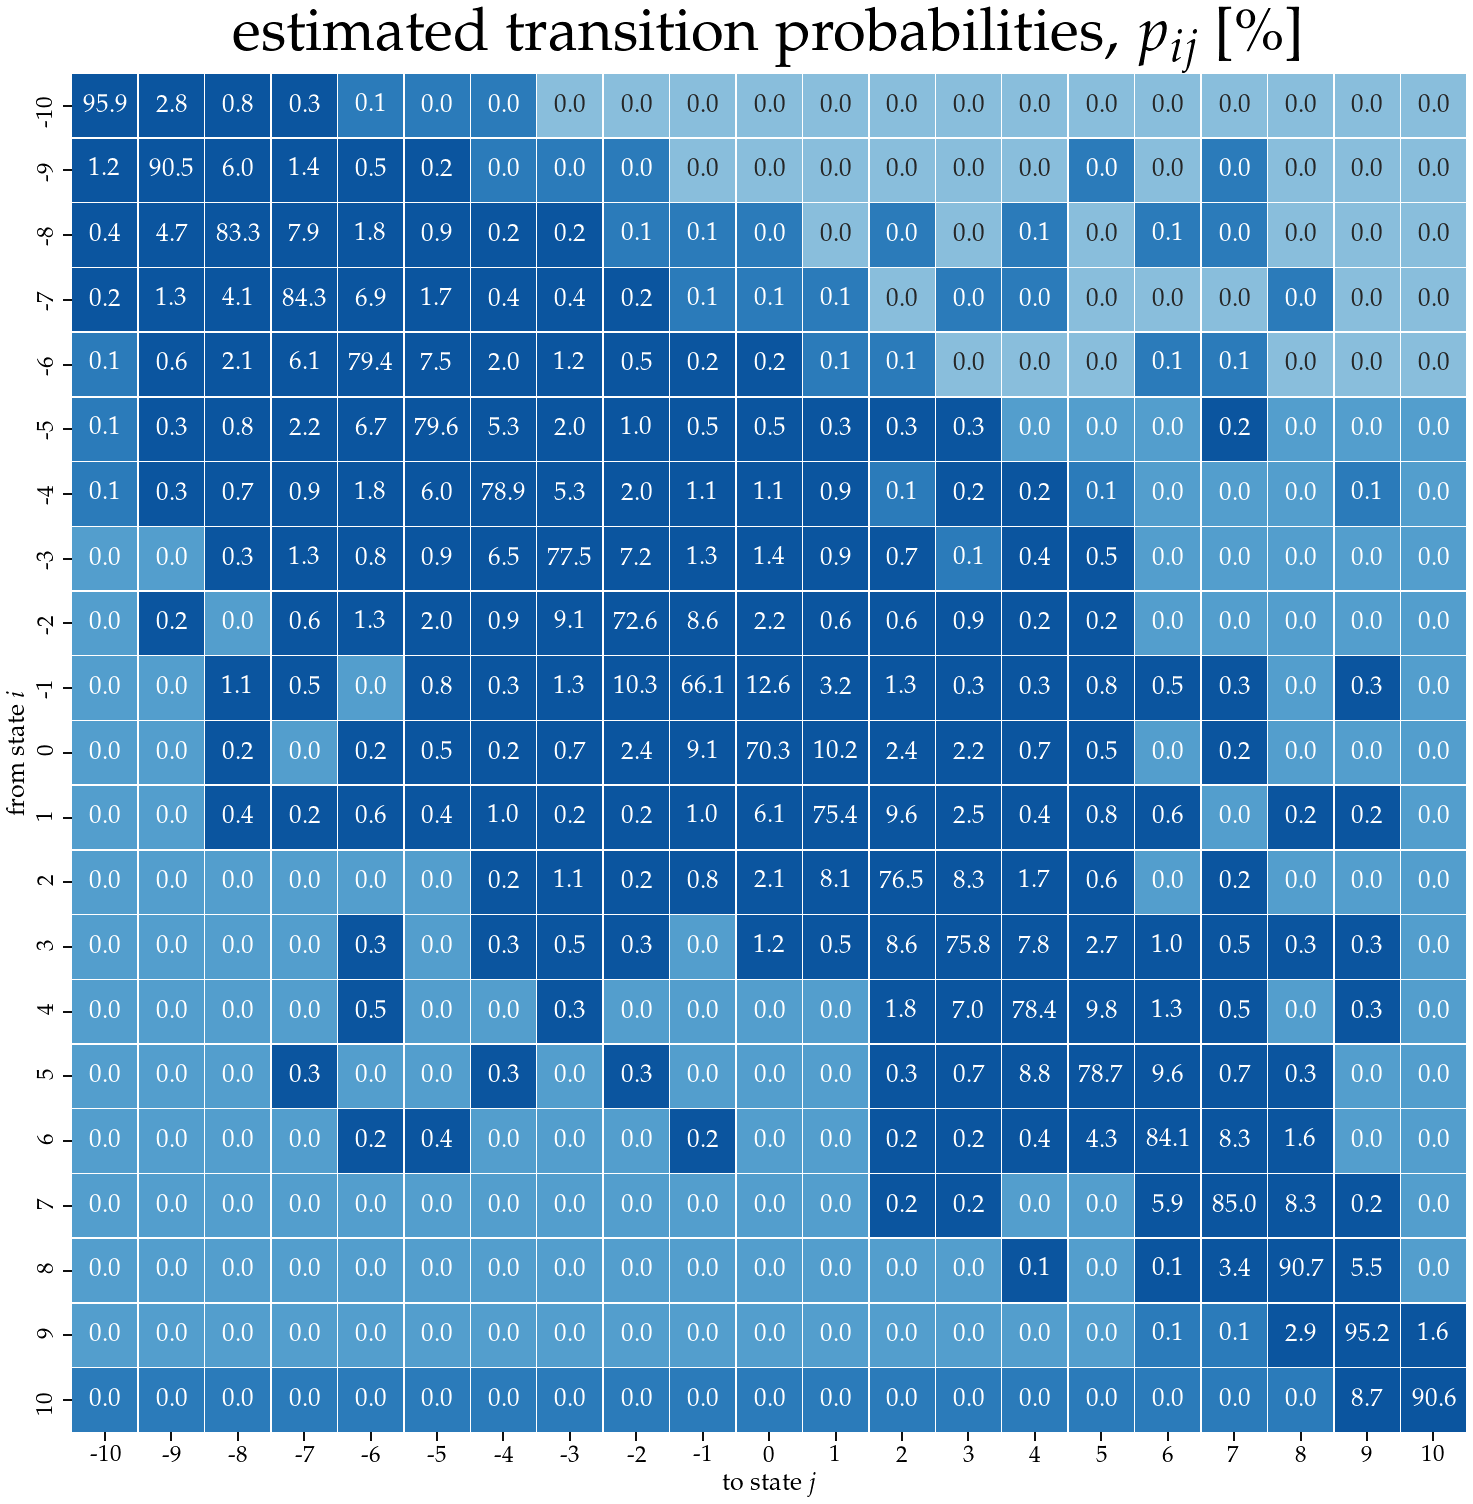

In [51]:
x_axis_labels = np.arange(-10,11,1)
y_axis_labels = np.arange(-10,11,1)
plt.figure(figsize=(25,25))
sns.heatmap(P_allCountries_Bayes*100, annot=True,fmt=".1f",cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels,norm=LogNorm(vmin=P_allCountries_Bayes.min(), vmax=P_allCountries_Bayes.max()), linewidths=.5,cmap=sns.color_palette("Blues"))
plt.ylabel(r'from state $i$')
plt.xlabel(r'to state $j$')
plt.title(r'estimated transition probabilities, $p_{ij}$ [$\%$]',size=60)

plt.savefig('./fig/transitionMatrix_Vdem.pdf',bbox_inches='tight')


#plt.savefig('./../results/figures/Fig2-estimatedTransitionProbabilities.pdf',bbox_inches='tight')

In [34]:
#np.savetxt('./../results/transitionBayesAllCountries.csv',P_allCountries_Bayes)

## Compute the expected Change

In [35]:
# check for each state the expected change
# 1) create the change matrix

deltaS=np.zeros((21,21))
for K in np.arange(-20,21,1):
    deltaS = deltaS + K*np.eye(N=21,M=21,k=K)

    
weightedDeltaS = np.multiply(P_allCountries_Bayes,deltaS)
#
meanDeltaS = np.sum(weightedDeltaS,axis=1)

In [36]:
# least square fit of cubical Polynomial curve to data
from scipy.optimize import curve_fit

x=np.arange(-10,11,1)

def poly3(x,a,b,c,d):
    return(a*x**3+b*x**2+c*x+d)

param, param_cov = curve_fit(poly3, x, meanDeltaS)

xPlot = np.arange(-10,11,0.01)
yPlot = poly3(xPlot,param[0],param[1],param[2],param[3])

In [37]:
param

array([ 7.89082900e-05, -1.67209720e-04, -1.63853565e-02,  3.43997053e-02])

In [38]:
### Least square fit of the quadratic form of p_{ii} (i)

x=np.arange(-10,11)
p_ii = np.diag(P_allCountries_Bayes)

def quadratic(x,a,b):
    return(a*x**2+b)

paramQuadratic, param_cov = curve_fit(quadratic, x, p_ii)


xPlot = np.arange(-10,11,0.01)
yPlotQuadratic = quadratic(xPlot,paramQuadratic[0],paramQuadratic[1])

In [39]:
paramQuadratic

array([0.00220634, 0.73270724])

Text(0, 0.5, 'remain probability, $p_{ss}$')

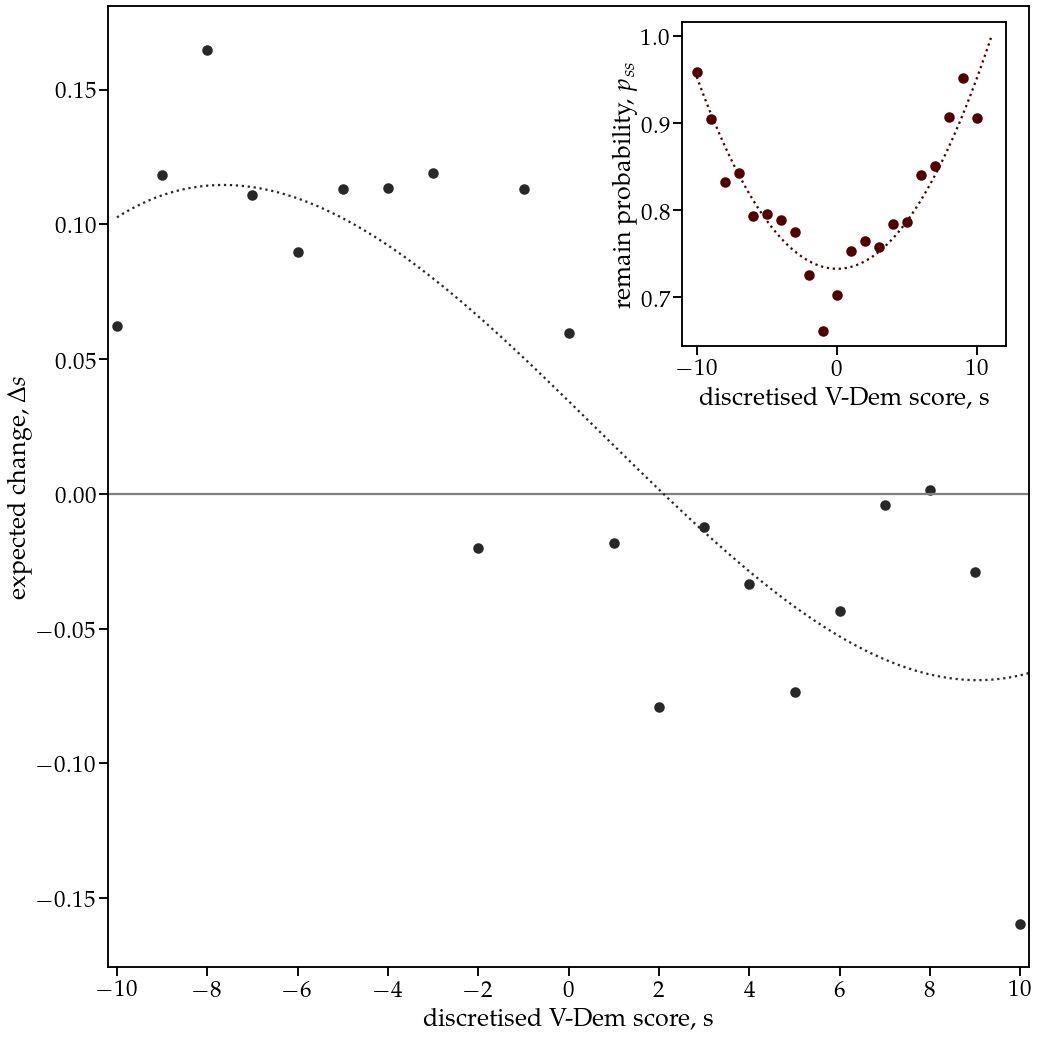

In [47]:
# colors for plotting
teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()







# plotting
fig, ax1 = plt.subplots(figsize=(15,15))
color1 = '#282828'
plt.scatter(np.arange(-10,11,1),meanDeltaS,color=color1,marker='o', facecolors=color1)
# horzintal line indiacting zero
plt.hlines(y=0,xmin=-11,xmax=11,linestyles='solid',color='#808080')
# plot fit line
plt.plot(xPlot,yPlot,color=color1,linestyle=':')



plt.ylabel(r'expected change, $\Delta s$')
plt.xlabel(r'discretised V-Dem score, s')

plt.xlim([-10.2,10.2])
plt.xticks(np.arange(-10,11,2))


#ax1.set_ylim(-0.35,0.35)
fig.tight_layout() 

# add arrows to highlight
teal = [0,0.5,0.5]
lightgray = [0.53,0.53,0.53]
purple = [0.5,0.0,0.5]

# ax1.annotate('full autocracies are\n relatively stable', xy=(-9.5, 0.06),
#              xycoords='data',
#              xytext=(-9.6, -0.06),
#              textcoords='data',
#              color=teal,
#              arrowprops=dict(arrowstyle= '-|>',
#                              color=teal,
#                              lw=3.5,
#                              ls='-')
#            )

# ax1.annotate('full democracies are\n relatively stable', xy=(9.8, -0.02),
#              xycoords='data',
#              xytext=(8.3, -0.06),
#              textcoords='data',
#              color=purple,
#              ha='right',
#              arrowprops=dict(arrowstyle= '-|>',
#                              color=purple,
#                              lw=3.5,
#                              ls='-')
#            )

# ax1.annotate('in mixed regimes, transitions\n balance each other out', xy=(-0.1, -0.05),
#              xycoords='data',
#              xytext=(-7.6, -0.22),
#              textcoords='data',
#              color=lightgray,
#              arrowprops=dict(arrowstyle= '-|>',
#                              color=lightgray,
#                              lw=3.5,
#                              ls='-')
#            )



# add inlay of quadratic form of p_{ii}
#vmaxAll = 0.32


color2='#500000'

subax1 = fig.add_axes([0.65,0.66,0.3,0.3])
plt.scatter(x=x,y=p_ii,color=color2,marker='o', facecolors=color2)
# plot fit line
plt.plot(xPlot,yPlotQuadratic,color=color2,linestyle=':')
plt.xlabel(r'discretised V-Dem score, s')
plt.ylabel(r'remain probability, $p_{ss}$')




#plt.savefig('./../results/figures/Fig3-expectedDeltaS.pdf',bbox_inches='tight')

### Steady State

In [41]:
def computeSteadyStateEV(transitionMatrix):
    # compute it as eigenvector
    valsT, vecsT = np.linalg.eig(transitionMatrix.transpose())
    
    # find the index of the eigenvalue closest to 1
    index_ev1 = (np.abs(valsT - 1)).argmin()
    
    v = vecsT[:,index_ev1]
    return((v/np.sum(v)).real) # normalise it for the return and also ignore the imaginary part (from numerical approx.)


In [42]:
# compute steady state
steadyStateEV = computeSteadyStateEV(P_allCountries_Bayes)

In [43]:
# plot the distribution at earlier times
[hist1800,binEdges ] = np.histogram(timeSeriesVDEM[timeSeriesVDEM['year']==1800]['v2x_polyarchy_discretised'],np.arange(-10,12))
[hist1900,binEdges ] = np.histogram(timeSeriesVDEM[timeSeriesVDEM['year']==1900]['v2x_polyarchy_discretised'],np.arange(-10,12))
[hist2000,binEdges ] = np.histogram(timeSeriesVDEM[timeSeriesVDEM['year']==2000]['v2x_polyarchy_discretised'],np.arange(-10,12))
[hist2018,binEdges ] = np.histogram(timeSeriesVDEM[timeSeriesVDEM['year']==2018]['v2x_polyarchy_discretised'],np.arange(-10,12))

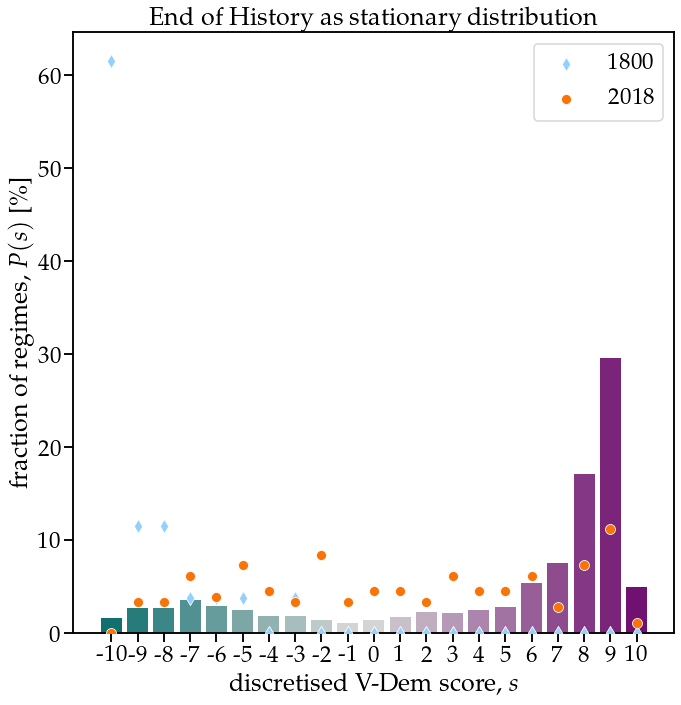

In [52]:
# plot the steady state
plt.figure(figsize=(10,10))
steadyState=pd.DataFrame()
steadyState['fraction'] = 100*steadyStateEV
steadyState['regime'] = np.arange(-10,11,1)

teal = [0,0.5,0.5]
lightgray = [0.83,0.83,0.83]
purple = [0.5,0.0,0.5]

clrs = [teal,lightgray,purple]
clrs1 = np.linspace(teal, lightgray, 10, axis=1)
clrs2 = np.linspace(lightgray, purple, 11, axis=1)

clrs = np.concatenate((clrs1,clrs2), axis=1)

clrsL = np.transpose(clrs).tolist()


g=sns.barplot(x="regime", y="fraction", data=steadyState,palette=clrsL)


sns.scatterplot(x=np.arange(0,21),y=100*hist1800/np.sum(hist1800),marker='d',color=sns.xkcd_rgb['light blue'], s=100,zorder=10,label=r'1800')
sns.scatterplot(x=np.arange(0,21),y=100*hist2018/np.sum(hist2018),marker='o',color=sns.xkcd_rgb['orange'], s=100, zorder=11,label=r'2018')
plt.legend(loc=0)
plt.tight_layout()
plt.title('End of History as stationary distribution')
plt.xlabel(r'discretised V-Dem score, $s$')
plt.ylabel(r'fraction of regimes, $P(s)$ [$\%$]')

plt.savefig('./fig/EoH_Vdem.pdf',bbox_inches='tight')

#plt.savefig('./figures/distributionAndSteadyStateBarplot.pdf')
#plt.savefig('./../results/figures/Fig4-distributionAndSteadyStateBarplot.pdf',bbox_inches='tight')




In [59]:
np.sum(steadyStateEV[0:10])

0.2231110405526026

In [66]:
np.sum(steadyStateEV[17:21])

0.5925323762334489

In [64]:
steadyState

,fraction,regime
0,1.631596,-10
1,2.688523,-9
2,2.674245,-8
3,3.558656,-7
4,2.897783,-6
5,2.537989,-5
6,1.869855,-4
7,1.845717,-3
8,1.462643,-2
9,1.144096,-1
